[ 0.  0.  0.]
reward: 0 step: 319 last: [-0.03857558]


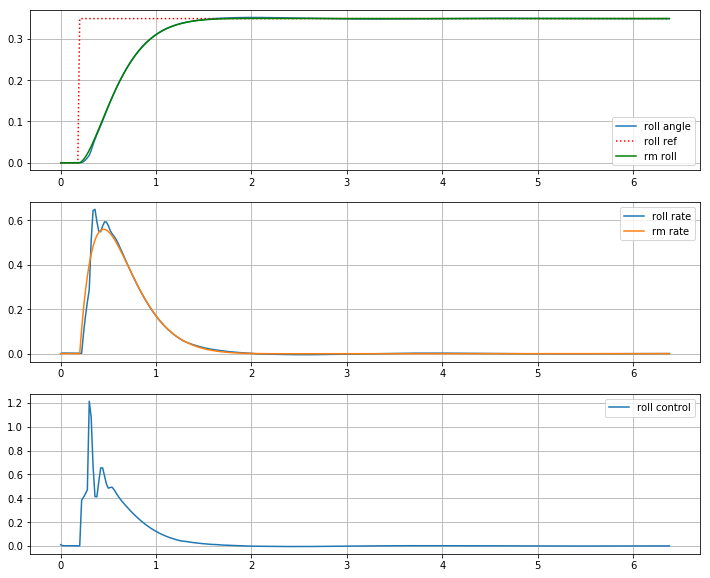

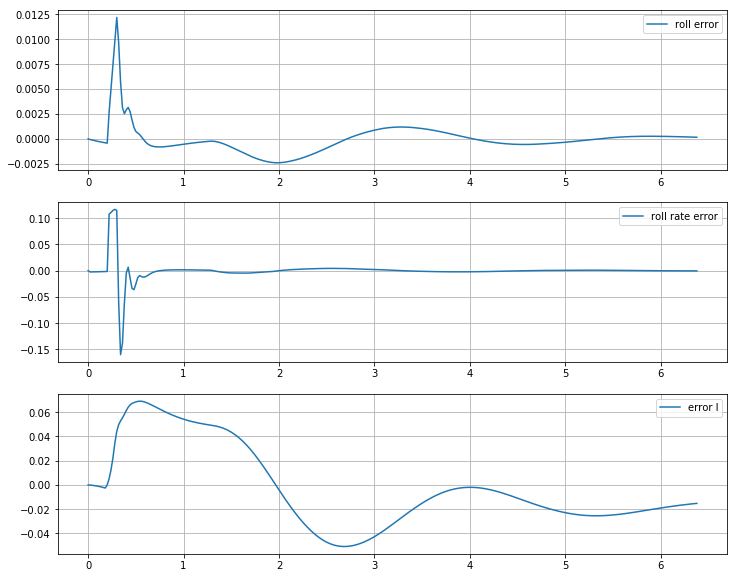

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UAV_test_Simulator_SSmodel_50Hz import UAV_Attitude_Simulator

import torch
import TD3
import utils

def process_state(s):
    return np.reshape(s, [1, -1])

def process_action(a):
    K = 1.0
    return K * a

env = UAV_Attitude_Simulator()

state_dim = 3
action_dim = 1
max_action = 3
dt = 0.02

args = {
    'start_timesteps':1e4,
    'eval_freq': 5e3,
    'expl_noise': 0.1,
    'batch_size': 256,
    'discount': 0.99,
    'tau': 0.005,
    'policy_noise': 0.2,
    'noise_clip': 0.5,
    'policy_freq': 2
}

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": args['discount'],
    "tau": args['tau'],
}

# Target policy smoothing is scaled wrt the action scale
kwargs["policy_noise"] = args['policy_noise'] * max_action
kwargs["noise_clip"] = args['noise_clip'] * max_action
kwargs["policy_freq"] = args['policy_freq']
policy = TD3.TD3(**kwargs)
policy.load('TD3models/Atti_Models/ctrlmodel_84999')  # from xxx

rewardlog = []
T = []

rolllog = []
rollratelog = []
drolllog = []
mrolllog = []
rmrolllog = []
rmratelog = []
integerlog = []
erolllog = []
eratelog = []
done = False
episode_reward = 0
episode_timesteps = 0

# set initial d_atti
atti0 = 0.0
rate0 = 0.0
env.d_atti = 0.0
env.uav.reset(atti0)

state = env.observe()
print(state)
for step in range(320):
    # set d_atti
    if step < 10:
        env.d_atti = np.array([0.0])
    if step >= 10:
        env.d_atti = np.array([20.0/180.0*np.pi])    
    #env.d_atti = np.array([0.0])
    time = step * dt
    T.append(time)
    
    action = policy.select_action(state)
    action_in = process_action(action)
    
#     print 'state:', state
#     print 'action:', action
    
    # log motions
    erolllog.append(env.refmodel.refroll - env.uav.roll)
    eratelog.append(env.refmodel.refrollrate - env.uav.rollrate)
    rolllog.append(env.uav.roll)
    rollratelog.append(env.uav.rollrate)
    drolllog.append(env.d_atti)
    mrolllog.append(action)
    rmrolllog.append(env.refmodel.refroll)
    rmratelog.append(env.refmodel.refrollrate)
    # perform action
    next_state, reward, done, integr= env.step(action_in)
    integerlog.append(integr)
    state = next_state
    if done: break

# End of Episode
rewardlog.append(episode_reward)
if env.ATTI_FAIL: print('Attitude out!')
if env.RATE_FAIL: print('Rate TOO Fast!')
print('reward:', episode_reward, 'step:', step, 'last:', env.r / np.pi * 180)


# T = np.linspace(0,16,len(rolllog))

plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
plt.plot(T, rolllog, label ='roll angle' )
plt.plot(T, drolllog, c='r', ls=':', label='roll ref')
plt.plot(T, rmrolllog, c='g', label='rm roll')
plt.grid()
plt.legend()
plt.subplot(3,1,2)
plt.plot(T, rollratelog, label='roll rate')
plt.plot(T, rmratelog, label='rm rate')
plt.grid()
plt.legend()
plt.subplot(3,1,3)
plt.plot(T, mrolllog, label='roll control')
plt.grid()
plt.legend()
plt.figure()
plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
plt.plot(T, erolllog, label ='roll error' )
plt.grid()
plt.legend()
plt.subplot(3,1,2)
plt.plot(T, eratelog, label='roll rate error')
plt.grid()
plt.legend()
plt.subplot(3,1,3)
plt.plot(T, integerlog, label='error I')
plt.grid()
plt.legend()
plt.show()


In [2]:
state = np.array([0.8,0.0])
action = policy.select_action(state)
print (action)

[ 0.38713694]
